In [1]:
from sklearn import metrics

In [5]:
import numpy as np
import cv2  
import os,glob,tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from tensorflow.keras import optimizers,losses
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from PIL import Image
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

图像形状: (512, 770, 3)


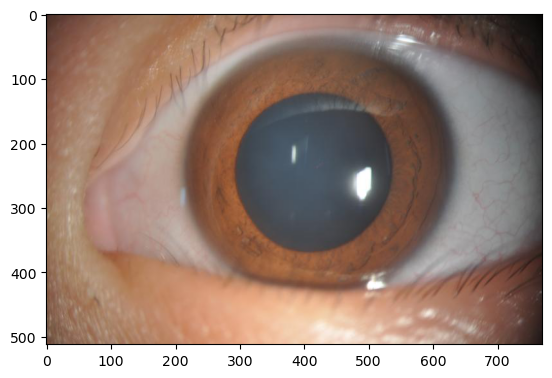

In [6]:
img = Image.open('./tester01/normal/normal-2.jpeg')
plt.imshow(img)
img_np = np.array(img)
print("图像形状:", img_np.shape)

In [7]:
# 定义数据路径
data_dir = './tester01' 
# 加载数据集
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])
# 加载原始数据集
original_dataset = datasets.ImageFolder(root=data_dir,transform=transform1)

In [8]:

# 定义数据增强和转换
transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

In [9]:
# 对原始数据集进行增强和转换
augmented_dataset = datasets.ImageFolder(root=data_dir, transform=transform2)

# 显示增强前后的数据量
print(f"原始数据集大小: {len(original_dataset)}")
print(f"增强后的数据集大小: {len(augmented_dataset)}")
# 合并数据集
dataset = torch.utils.data.ConcatDataset([original_dataset, augmented_dataset])
print(f"增强后的总的数据集大小: {len(dataset)}")


原始数据集大小: 3064
增强后的数据集大小: 3064
增强后的总的数据集大小: 6128


In [16]:
# 设置随机种子
seed_value = 42
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
# 划分数据集为训练集、验证集和测试集

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

In [17]:
cataract_num = 0
normal_num = 0
surgery_num=0
for x,y in train_dataset:
    if y == 0:
        cataract_num += 1
    elif y == 1:
        normal_num += 1
    elif y==2:
        surgery_num+=1
 
print("cataract_num: ",cataract_num)
print("normal_num: ",normal_num)
print(" surgery_num: ", surgery_num)

cataract_num:  1621
normal_num:  1081
 surgery_num:  1587


In [18]:
# 定义数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)


In [19]:
# 定义 CNN 模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, 3)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

In [20]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# 训练模型
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader)}")


Epoch 1/10 - Loss: 0.36241534462681524
Epoch 2/10 - Loss: 0.10269093578336394
Epoch 3/10 - Loss: 0.06683996578372495
Epoch 4/10 - Loss: 0.058421256528580906
Epoch 5/10 - Loss: 0.037265317222368644
Epoch 6/10 - Loss: 0.01732180333259647
Epoch 7/10 - Loss: 0.007825134358427022
Epoch 8/10 - Loss: 0.0074392238303887465
Epoch 9/10 - Loss: 0.08481284082404777
Epoch 10/10 - Loss: 0.012573659736275052


In [84]:
# 模型测试
model.eval()
predictions = []
true_labels = []
correct = 0 
total = 0 
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()# 
 
print(f"Val Accuracy: {correct / total * 100}%")

Val Accuracy: 98.69494290375204%


In [29]:
from sklearn.metrics import classification_report

# 获取每个类别的准确预测数
class_correct = [0] * 3
class_total = [0] * 3
class_names=["cataract","normal","surgery"]
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_tensor = predicted.eq(labels.data.view_as(predicted))
        correct = np.squeeze(correct_tensor.numpy())

        # 更新每个类别的准确预测数和总数
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# 计算每个类别的准确率
for i in range(3):
    if class_total[i] > 0:
        print(f"Accuracy of {class_names[i]} : {100 * class_correct[i] / class_total[i]}%")
    else:
        print(f"Accuracy of {class_names[i]} : N/A (no validation data for this class)")


Accuracy of cataract : 98.20089955022489%
Accuracy of normal : 99.36305732484077%
Accuracy of surgery : 98.43081312410841%


In [85]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
predictions

[0,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 1,
 1,


In [86]:
# 筛选出 Cataract 类和 Normal 类的标签和预测值
cataract_indices = [i for i, label in enumerate(true_labels) if label == 0] 
normal_indices = [i for i, label in enumerate(true_labels) if label == 1]  

cataract_labels = [true_labels[i] for i in cataract_indices if i < len(predictions)]
normal_labels = [true_labels[i] for i in normal_indices if i < len(predictions)]

cataract_predictions = [predictions[i] for i in cataract_indices if i < len(predictions)]
normal_predictions = [predictions[i] for i in normal_indices if i < len(predictions)]


# 计算 ROC 曲线和 AUC
labels = cataract_labels + normal_labels
predictions = cataract_predictions + normal_predictions
fpr, tpr, thresholds = roc_curve(labels, predictions)
auc = roc_auc_score(labels, predictions)

# 打印结果
print(f"AUC (Cataract vs Normal): {auc}")

AUC (Cataract vs Normal): 0.9835846408006188


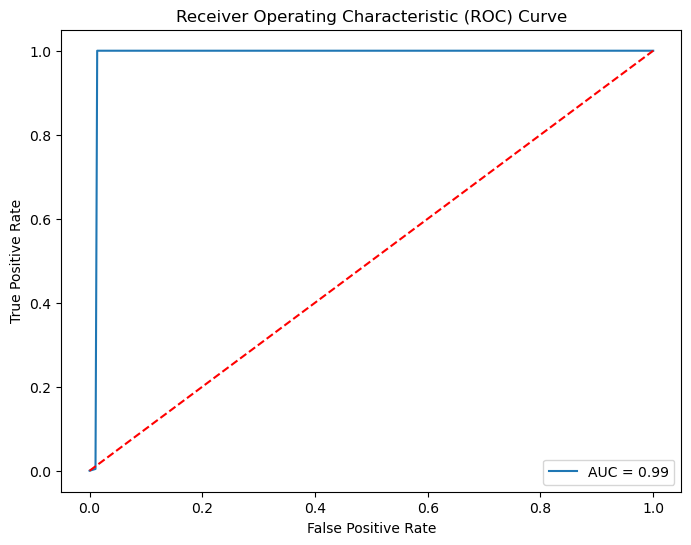

In [65]:
# 绘制 ROC 曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [87]:
from sklearn.metrics import confusion_matrix

# 获取混淆矩阵
conf_matrix = confusion_matrix(labels, predictions)

# 计算敏感性和特异性
true_positives = conf_matrix[0][0]
false_negatives = conf_matrix[0][1]
true_negatives = conf_matrix[1][1]
false_positives = conf_matrix[1][0]

sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# 打印结果
print(f"Sensitivity (Cataract): {sensitivity}")
print(f"Specificity (Normal): {specificity}")

Sensitivity (Cataract): 0.9969558599695586
Specificity (Normal): 1.0


In [24]:
# 保存模型
torch.save(model.state_dict(), 'model.pth')